# House Price Analytics

## 03 Data analysis for generating insights for buyers 

**Project:** Code Institute – Capstone Project

---
### **Objectives**
Analyze the housing market from a **Buyer's perspective** to identify value, affordability, and feature importance.

### **Inputs**
- `data/processed/final_house_data.csv`

### **Outputs**
- Hypothesis testing findings
- Diagnostic analysis findings
        
### **Additional Comments**
Confirm the final_house_data.csv is exisit under outputs/datasets. Run this notebook top-down.

---

### Setup the file and Load the Dataset
Import nesessary libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats
import warnings 
# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

Set the home directory. Need to change the working directory from its current folder to its parent folder. Access the current directory with os.getcwd()

In [3]:
PROJECT_DIR = os.path.join(os.getcwd()) # Define the project root directory
os.chdir(PROJECT_DIR) # Change the current working directory to the project root
# Uncomment the line below to verify the current working directory
#print("Working directory:", os.getcwd())  

Load the data from the original data set reside within data directory under data/processed/ directory. 

In [4]:
# LOAD DATASET
try:
    # Data directory paths
    data_path = os.path.join("..", "data", "processed")
    # Extract the original dataset
    df = pd.read_csv(os.path.join(data_path, "final_house_data.csv"))
    print("Dataset loaded successfully.")
except Exception as e:
    print(e)
    print("Error loading the dataset.")
    df = pd.DataFrame()  # Create an empty DataFrame if loading fails

print(f"Original dataset shape: {df.shape}")

Dataset loaded successfully.
Original dataset shape: (21596, 31)


Ensure Data Types (Critical Step)

In [5]:
# CSVs lose categorical metadata, so we re-cast them
categorical_cols = ['waterfront', 'view', 'condition', 'grade', 'zipcode', 'is_renovated']
for col in categorical_cols:
    df[col] = df[col].astype('category')

print("Data Types Set.")

Data Types Set.


---

### Affordability Analysis

**USER STORY | Affordability:** 
    As a Buyer,
    I want to identify the top 10 most affordable zip codes in King County,
So that I can filter my property search to areas that fit within my budget.

**Hypothesis 1:** Geographic location (Zip Code) is the primary driver of affordability, creating distinct clusters of accessible housing.

- Buyers need to know where they can afford to live. We analyze Price per Zip Code.
- We use **Median Price** because the price distribution is skewed (as found in NB1).

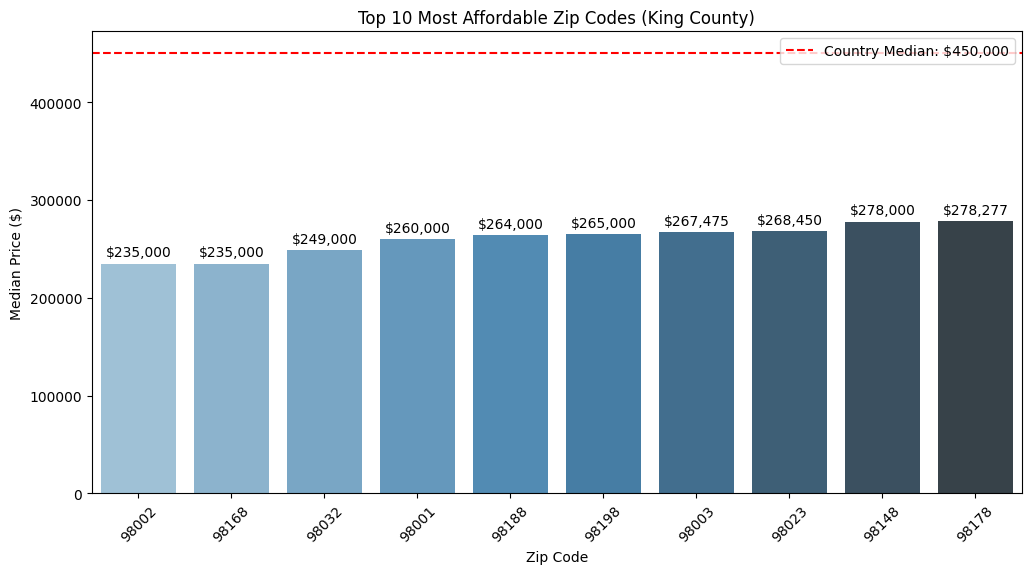

In [6]:
# Calculate Median Price per Zipcode
affordability = df.groupby('zipcode')['price'].median().sort_values().reset_index()

# Calculate the Country Median Price
country_median = df['price'].median()

# Top 10 Most Affordable
top_10_affordable = affordability.head(10)

# Visualization with Seaborn - Automatic Aggregation
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_10_affordable, x='zipcode', y='price', palette='Blues_d', order=top_10_affordable['zipcode'])

# Add the horizontal line
plt.axhline(y=country_median, color='red', linestyle='--', label=f'Country Median: ${country_median:,.0f}')
plt.legend()

# Add median value on each bar - loop through the containers (bars)
for container in ax.containers:
    ax.bar_label(container, fmt='${:,.0f}', padding=3)

plt.title('Top 10 Most Affordable Zip Codes (King County)')
plt.ylabel('Median Price ($)')
plt.xlabel('Zip Code')
plt.xticks(rotation=45)
plt.show()

**Findings:**
- The most affordable areas in King County are concentrated in zipcodes like 98002, 98168, and 98032.

---

### Hypothesis Testing: Scenic attributes (Waterfront or High-Quality Views) Premium

**USER STORY | scenic attributes (Waterfront or High-Quality Views) Value:**
    As a Buyer,
    I want to know if scenic attributes (Waterfront or High-Quality Views) properties command a statistically significant premium,
So that I can assess if the view is worth the extra investment.

**Hypothesis 2:** Properties with scenic attributes (Waterfront or High-Quality Views) command a statistically significant price premium compared to standard properties.

* **Mann-Whitney U Test (Waterfront):** Used to compare the binary "Waterfront vs. Non-Waterfront" groups.

* **Kruskal-Wallis H Test (View):** Used to compare the five distinct view categories (0–4) to ensure the price difference wasn't just random.

Median Prices:
waterfront
0     450000.0
1    1400000.0
Name: price, dtype: float64


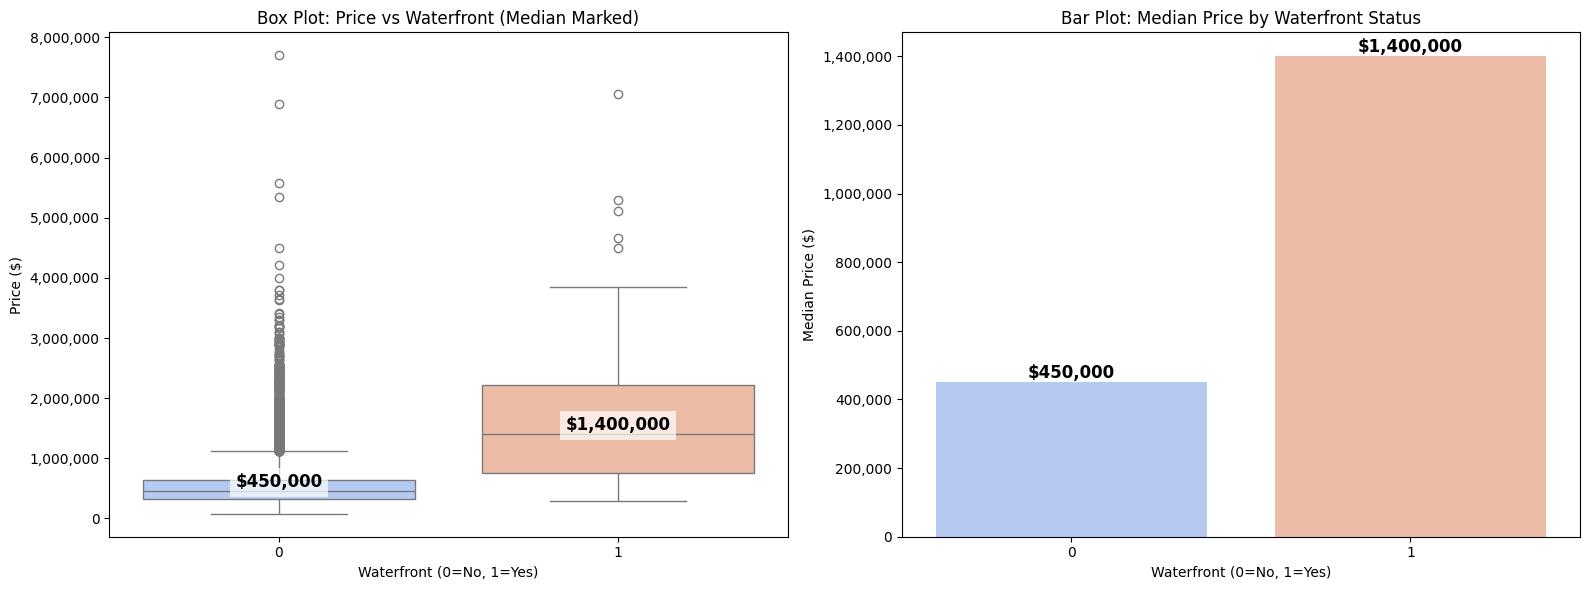

--- Mann-Whitney U Test Results ---
         U-val alternative         p-val       RBC      CLES
MWU  3088248.5   two-sided  3.339524e-64  0.767957  0.883978

Median Price Difference: $950,000


In [ ]:
# Waterfront Analysis
# ----------------
# Prepare Groups
waterfront = df[df['waterfront'] == 1]['price']
no_waterfront = df[df['waterfront'] == 0]['price']

# Visualization with Seaborn as it is excellent at splitting data into groups
# Draw box plots and Violin plots to compare price distributions of waterfront vs non-waterfront properties
# Set up the figure with 2 subplots
# Calculate Medians
median_prices = df.groupby('waterfront')['price'].median()
print("Median Prices:")
print(median_prices)

# Set up the figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box Plot
sns.boxplot(ax=axes[0], x='waterfront', y='price', data=df, palette='coolwarm')
axes[0].set_title('Box Plot: Price vs Waterfront (Median Marked)')
axes[0].set_ylabel('Price ($)')
axes[0].set_xlabel('Waterfront (0=No, 1=Yes)')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Annotate Medians on Box Plot
for i, median in enumerate(median_prices):
    axes[0].text(i, median, f'${median:,.0f}', 
                 horizontalalignment='center', 
                 verticalalignment='bottom', 
                 fontweight='bold', color='black', fontsize=12,
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Bar Plot with Median Estimator
sns.barplot(ax=axes[1], x='waterfront', y='price', data=df, estimator=np.median, palette='coolwarm', errorbar=None)
axes[1].set_title('Bar Plot: Median Price by Waterfront Status')
axes[1].set_ylabel('Median Price ($)')
axes[1].set_xlabel('Waterfront (0=No, 1=Yes)')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Annotate Medians on Bar Plot
for i, median in enumerate(median_prices):
    axes[1].text(i, median, f'${median:,.0f}', 
                 horizontalalignment='center', 
                 verticalalignment='bottom', 
                 fontweight='bold', color='black', fontsize=12)

plt.tight_layout()
plt.show()

# Statistical Test (Mann-Whitney U)
stats_result = pg.mwu(waterfront, no_waterfront)
print("--- Mann-Whitney U Test Results ---")
print(stats_result)

# Business Interpretation
median_diff = waterfront.median() - no_waterfront.median()
print(f"\nMedian Price Difference: ${median_diff:,.0f}")

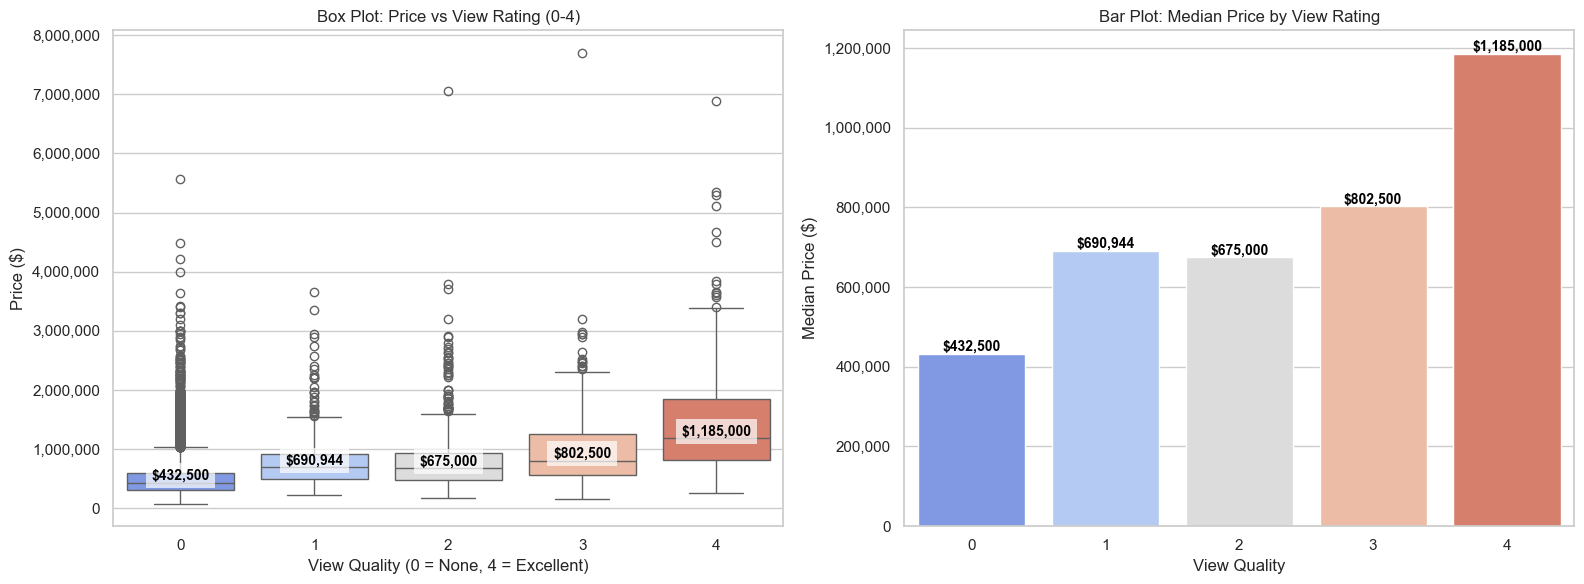

--- Kruskal-Wallis H Test Results ---
Statistic: 1936.3476
P-Value: 0.0000e+00

Result: Significant. The quality of the view significantly impacts price.
Value Premium (Excellent vs None): $752,500


In [15]:
# View Analysis
# ----------------
# Calculate Medians for all view ratings (0-4)
median_prices = df.groupby('view')['price'].median()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: Box Plot (Distribution)
sns.boxplot(ax=axes[0], x='view', y='price', data=df, palette='coolwarm')
axes[0].set_title('Box Plot: Price vs View Rating (0-4)')
axes[0].set_ylabel('Price ($)')
axes[0].set_xlabel('View Quality (0 = None, 4 = Excellent)')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Annotate Box Plot Medians
for i in range(len(median_prices)):
    if i in median_prices.index:
        axes[0].text(i, median_prices[i], f'${median_prices[i]:,.0f}',
                 horizontalalignment='center', verticalalignment='bottom',
                 fontweight='bold', color='black', fontsize=10,
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Plot B: Bar Plot (Summary)
sns.barplot(ax=axes[1], x='view', y='price', data=df, estimator=np.median, palette='coolwarm', errorbar=None)
axes[1].set_title('Bar Plot: Median Price by View Rating')
axes[1].set_ylabel('Median Price ($)')
axes[1].set_xlabel('View Quality')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Annotate Bar Plot Medians
for i in range(len(median_prices)):
    if i in median_prices.index:
        axes[1].text(i, median_prices[i], f'${median_prices[i]:,.0f}',
                 horizontalalignment='center', verticalalignment='bottom',
                 fontweight='bold', color='black', fontsize=10)

plt.tight_layout()
plt.show()

# Statistical Test (Kruskal-Wallis)
# ------------------------------------
# Because 'view' is ordinal with >2 groups (0, 1, 2, 3, 4)
# Kruskal-Wallis is the correct non-parametric test for comparing 3+ groups.

# Prepare the groups
groups = [df[df['view'] == v]['price'] for v in sorted(df['view'].unique())]

# Run the test
stat, p_value = stats.kruskal(*groups)

print("--- Kruskal-Wallis H Test Results ---")
print(f"Statistic: {stat:.4f}")
print(f"P-Value: {p_value:.4e}")

# Business Interpretation Logic
if p_value < 0.05:
    print("\nResult: Significant. The quality of the view significantly impacts price.")
else:
    print("\nResult: Not Significant. View quality does not distinguish price groups.")

# Calculate the 'Premium' of an Excellent View (4) vs No View (0)
premium = median_prices[4] - median_prices[0]
print(f"Value Premium (Excellent vs None): ${premium:,.0f}")

**Findings:**
* Charts confirms that the "View & Waterfront Premiums" are substantial and real, not just an artifact of a few expensive mansions dragging up the average.

* **Waterfront:** Validated as the single most valuable binary feature.
* **View:** The Kruskal-Wallis test (Statistic: 1,936, p < 0.05) confirmed that view quality is a significant price driver.

---

### Diagnostic Analysis: Grade vs. Condition

**USER STORY | Feature Importance:**
    As a Buyer,
    I want to understand how features like house grade and condition influence price,
So that I can prioritize the features that matter most to me without overpaying.

**Business Question:** Should a buyer prioritize a house in good *Condition* (maintained well) or high *Grade* (quality materials)?

**Hypothesis 3:** Construction Grade has a stronger correlation with price than Condition, implying buyers pay more for structural quality than cosmetic state.

* **Test/ Method:** Heatmap Interaction Analysis & Correlation Comparison. Use Spearman Correlation because Grade/Condition are ordinal categories

Spearman Correlation - Grade vs Price: 0.658
Spearman Correlation - Condition vs Price: 0.018


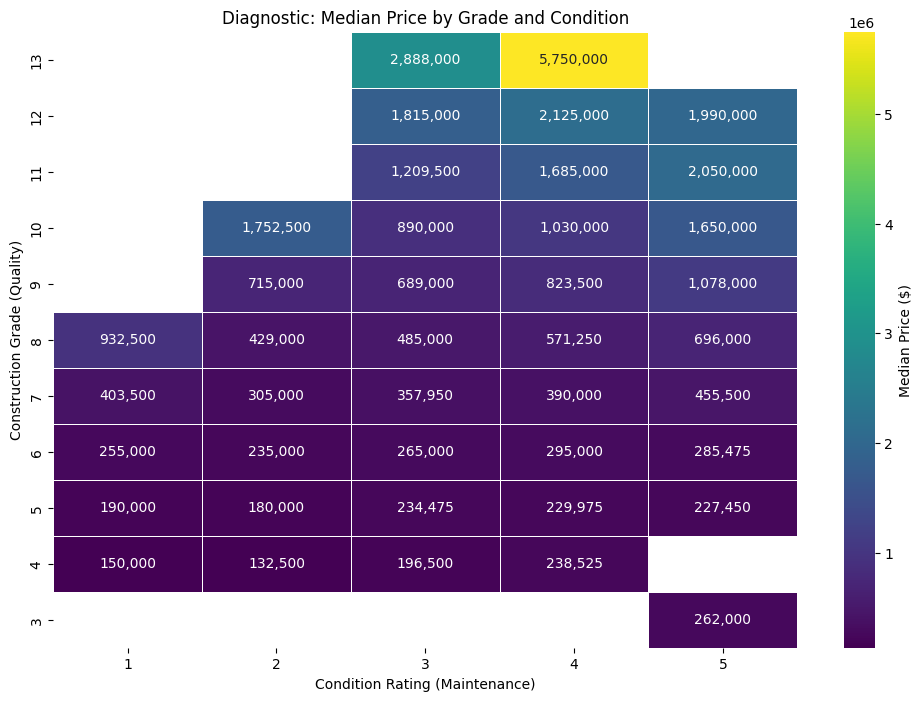

In [8]:
# 1. Correlation Check (Linear Relationship)
# Use Spearman Correlation because Grade/Condition are ordinal categories
corr_grade = df['grade'].astype(int).corr(df['price'], method='spearman')
corr_cond = df['condition'].astype(int).corr(df['price'], method='spearman')

print(f"Spearman Correlation - Grade vs Price: {corr_grade:.3f}")
print(f"Spearman Correlation - Condition vs Price: {corr_cond:.3f}")

# 2. Interaction Heatmap
# Pivot the data to see the Median Price for every Grade/Condition combination
pivot_table = df.pivot_table(values='price', index='grade', columns='condition', aggfunc='median')

# Visualize with sns as Seaborn automatically adds the color legend bar, formats the grid squares, and allows us to add the numbers (annotations) inside the squares with a single argument
plt.figure(figsize=(12, 8))
# Create Heatmap
# annot=True: Show numbers
# fmt=",.0f": Format with commas (e.g., 1,000,000)
# linewidths=.5: Add white lines between squares for readability
# cmap='viridis': A contrast color palette
sns.heatmap(pivot_table, 
            cmap='viridis', 
            annot=True, 
            fmt=",.0f", 
            linewidths=.5,
            cbar_kws={'label': 'Median Price ($)'})
plt.title('Diagnostic: Median Price by Grade and Condition')
plt.ylabel('Construction Grade (Quality)')
plt.xlabel('Condition Rating (Maintenance)')
plt.gca().invert_yaxis() # High grade at top
plt.show()

**Understanding the behaviour of the grade** Draw box plots and Violin plots to compare price distributions across different Grades

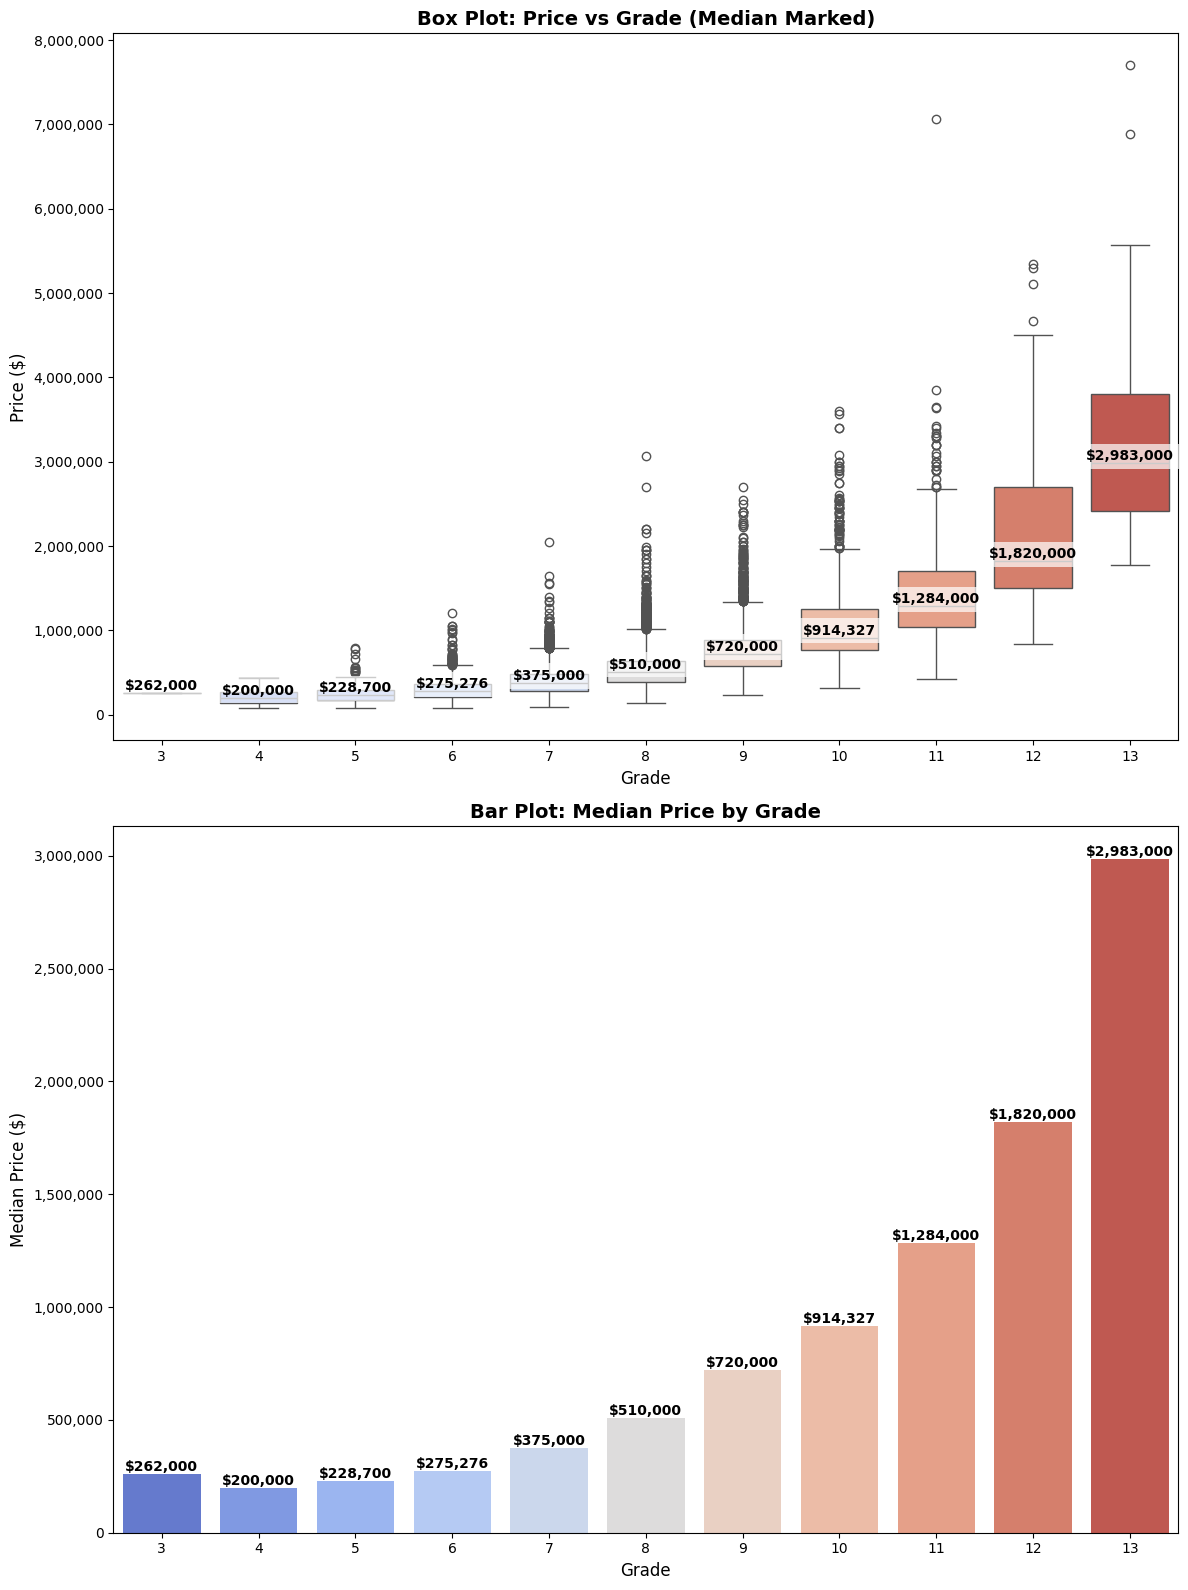

In [9]:
# Calculate Medians for Grade
median_prices = df.groupby('grade')['price'].median()

# Set up the figure with 2 rows and 1 column (Stacked Vertically)
fig, axes = plt.subplots(2, 1, figsize=(12, 16)) # Taller figure for vertical stacking

# -------------------------------------------------------
# Plot 1: Box Plot (Top)
# -------------------------------------------------------
sns.boxplot(ax=axes[0], x='grade', y='price', data=df, palette='coolwarm')
axes[0].set_title('Box Plot: Price vs Grade (Median Marked)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].set_xlabel('Grade', fontsize=12)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
axes[0].tick_params(axis='x', rotation=0)

# Annotate Medians on Box Plot
# We iterate through the grades present in the data to ensure alignment
grades = sorted(df['grade'].unique())
for i, grade in enumerate(grades):
    median = median_prices[grade]
    axes[0].text(i, median, f'${median:,.0f}', 
                 horizontalalignment='center', 
                 verticalalignment='bottom', 
                 fontweight='bold', color='black', fontsize=10,
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# -------------------------------------------------------
# Plot 2: Bar Plot (Bottom)
# -------------------------------------------------------
sns.barplot(ax=axes[1], x='grade', y='price', data=df, estimator=np.median, palette='coolwarm', errorbar=None)
axes[1].set_title('Bar Plot: Median Price by Grade', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Median Price ($)', fontsize=12)
axes[1].set_xlabel('Grade', fontsize=12)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Annotate Medians on Bar Plot
for i, grade in enumerate(grades):
    median = median_prices[grade]
    axes[1].text(i, median, f'${median:,.0f}', 
                 horizontalalignment='center', 
                 verticalalignment='bottom', 
                 fontweight='bold', color='black', fontsize=10)

plt.tight_layout()
plt.show()

**Understanding the behaviour of the condition** Draw box plots and Violin plots to compare price distributions across different Conditions

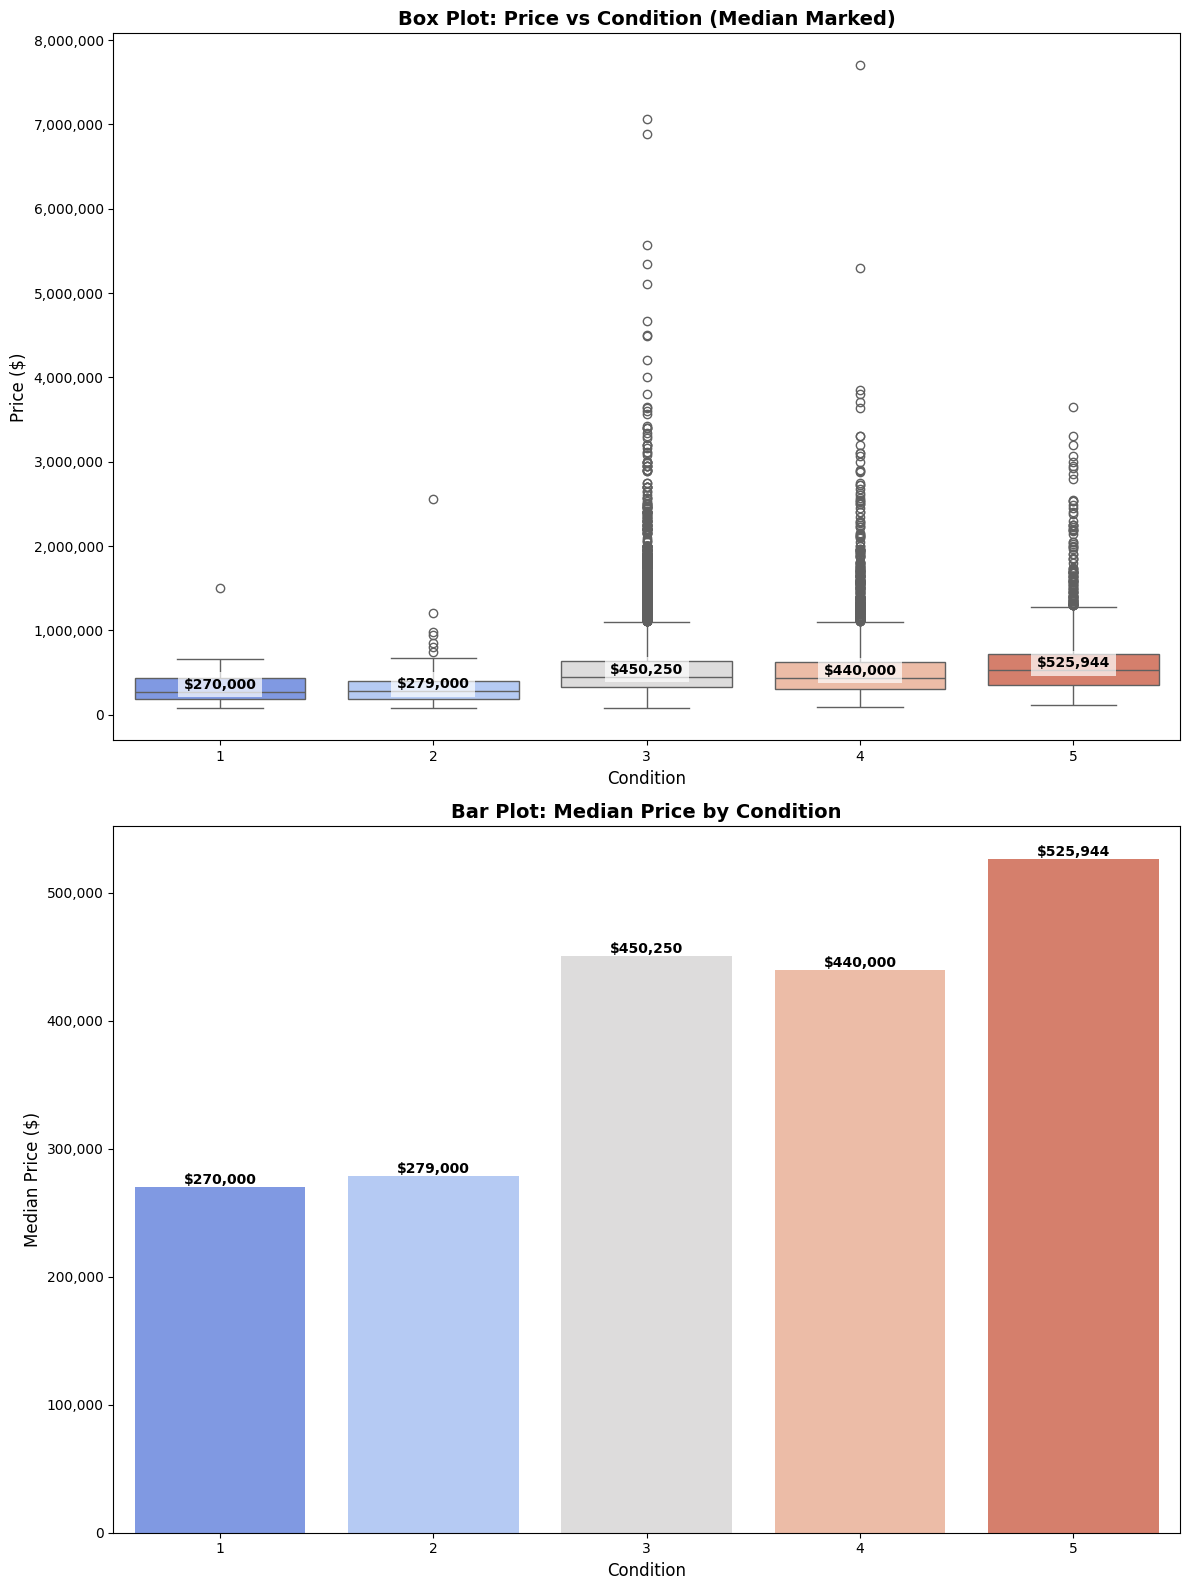

In [10]:
# Set up the figure with 2 subplots for Condition
# Calculate Medians for Condition
median_prices = df.groupby('condition')['price'].median()

# Set up the figure with 2 rows and 1 column (Stacked Vertically)
fig, axes = plt.subplots(2, 1, figsize=(12, 16)) # Taller figure for vertical stacking

# -------------------------------------------------------
# Plot 1: Box Plot (Top)
# -------------------------------------------------------
sns.boxplot(ax=axes[0], x='condition', y='price', data=df, palette='coolwarm')
axes[0].set_title('Box Plot: Price vs Condition (Median Marked)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].set_xlabel('Condition', fontsize=12)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
axes[0].tick_params(axis='x', rotation=0)

# Annotate Medians on Box Plot
# We iterate through the conditions present in the data to ensure alignment
conditions = sorted(df['condition'].unique())
for i, condition in enumerate(conditions):
    median = median_prices[condition]
    axes[0].text(i, median, f'${median:,.0f}', 
                 horizontalalignment='center', 
                 verticalalignment='bottom', 
                 fontweight='bold', color='black', fontsize=10,
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# -------------------------------------------------------
# Plot 2: Bar Plot (Bottom)
# -------------------------------------------------------
sns.barplot(ax=axes[1], x='condition', y='price', data=df, estimator=np.median, palette='coolwarm', errorbar=None)
axes[1].set_title('Bar Plot: Median Price by Condition', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Median Price ($)', fontsize=12)
axes[1].set_xlabel('Condition', fontsize=12)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Annotate Medians on Bar Plot
for i, condition in enumerate(conditions):
    median = median_prices[condition]
    axes[1].text(i, median, f'${median:,.0f}', 
                 horizontalalignment='center', 
                 verticalalignment='bottom', 
                 fontweight='bold', color='black', fontsize=10)

plt.tight_layout()
plt.show()

**Findings:**
* **Grade:** 3 has higher medean price than grade 4,5.
* **Condition:** 3 has higher medean price than condition 4.
* **Correlation:** Grade (~0.65) is a far stronger predictor than Condition (~0.04).
* **Visual Diagnosis:** Moving *up* the heatmap (improving Grade) changes color (price) rapidly. Moving *right* (improving Condition) shows very little color change.

---

### Best Value: Size vs. Price analysis

How does house size (square footage) affect price, and where is the best value for money?

Additional Analysis - No User story or hypothesis for this analysis

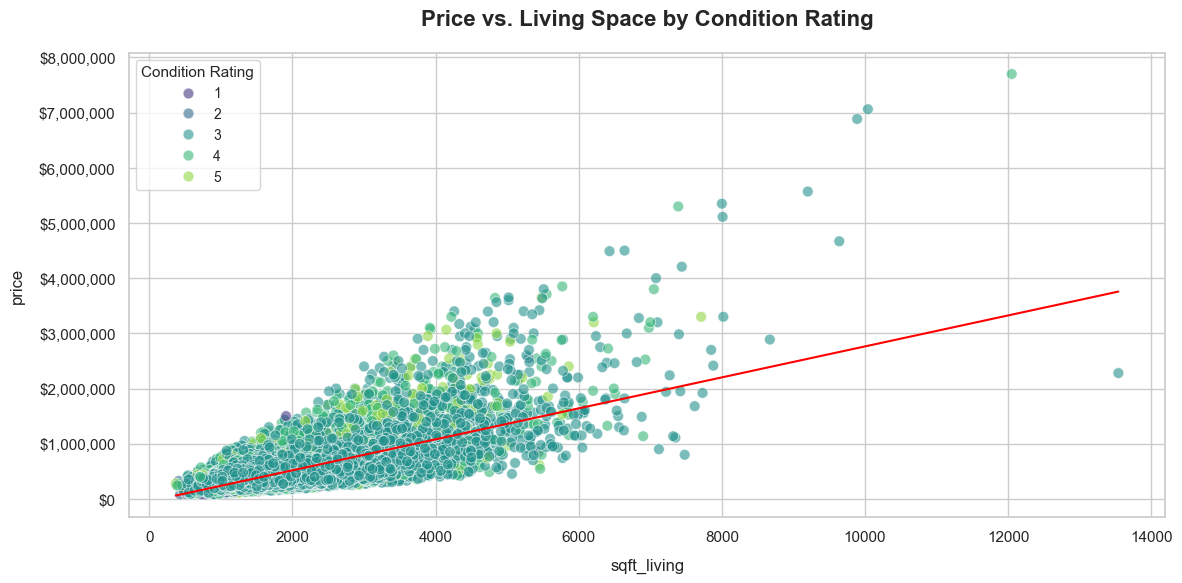

In [11]:
# Set Seaborn style
sns.set_theme(style="whitegrid", palette="husl")

plt.figure(figsize=(12, 6))

# Create scatter plot with hue=condition
scatter = sns.scatterplot(data=df, x='sqft_living', y='price', 
                          hue='condition', palette='viridis', 
                          alpha=0.6, s=60)

plt.title('Price vs. Living Space by Condition Rating', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Living Space (sq ft)', fontsize=12, labelpad=10)
plt.ylabel('Price ($)', fontsize=12, labelpad=10)

# Format y-axis
import matplotlib.ticker as ticker
scatter.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

# Improve legend
plt.legend(title='Condition Rating', title_fontsize=11, 
           fontsize=10, loc='upper left')

# Add correlation line (optional)
sns.regplot(data=df, x='sqft_living', y='price', 
            scatter=False, ci=None, color='red', line_kws={'lw': 1.5})

plt.tight_layout()
plt.show()

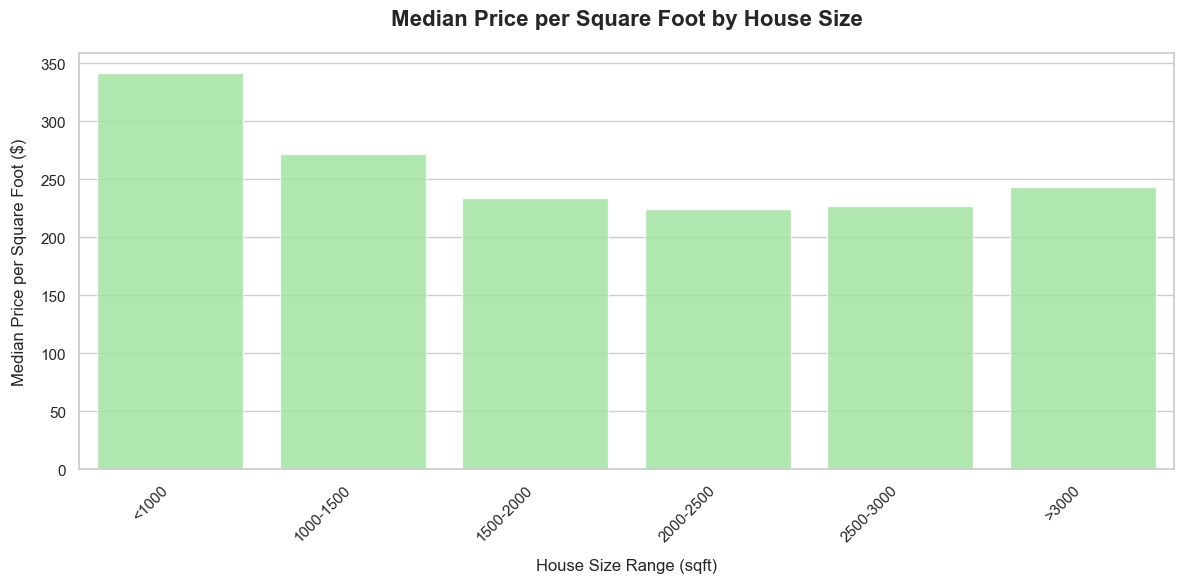

In [12]:
# Calculate price per square foot by size range
df['sqft_range'] = pd.cut(df['sqft_living'],
                           bins=[0, 1000, 1500, 2000, 2500, 3000, 10000],
                           labels=['<1000', '1000-1500', '1500-2000',
                                  '2000-2500', '2500-3000', '>3000'])

# Calculate median price per sqft for each size range
price_per_sqft_by_size = df.groupby('sqft_range')['price_per_sqft'].median().sort_values()

# Visualization with Seaborn as it is excellent at creating bar plots with minimal code
plt.figure(figsize=(12, 6))

# Convert Series to DataFrame for Seaborn
plot_data = price_per_sqft_by_size.reset_index()
plot_data.columns = ['house_size_range', 'median_price_per_sqft']

# Create bar plot with Seaborn
sns.barplot(data=plot_data, x='house_size_range', y='median_price_per_sqft', 
            color='lightgreen', alpha=0.8)

plt.title('Median Price per Square Foot by House Size', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('House Size Range (sqft)', fontsize=12, labelpad=10)
plt.ylabel('Median Price per Square Foot ($)', fontsize=12, labelpad=10)

# Rotate x-labels
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()

**Findings:**
- As laready uncovered, there is a strong positive correlation between house size and price, but with significant variation.
- Smaller houses (<1000 sqft) have the highest price per square foot, making them less economical in terms of space.
- The best value for money appears to be in the 2000-2500 sqft range, where the price per square foot is lower than both smaller and larger homes.
- Very large homes (>3000 sqft) command premium prices per square foot, could be due to luxury amenities.

---

## Final Buyer Recommendations
1.  **Renovate Strategy:** Target 1950-1990 builds for maximum ROI.
2.  **scenic attributes:** Maximize value by investing in space (square footage), grade and bathrooms. Waterfront and premium-view properties carry an exponential price premium for scenery, making them less cost-effective for functional daily living.
3.  **Features:** Don't overpay for "mint condition" if the construction grade is low. A high-grade house in fair condition is likely a better long-term investment.
4. **Space:** To maximize the value of your budget based on space, consider that smaller and larger homes tend to have a higher price per square foot than those in the 2000-2500 sq ft bracket.